In [4]:
import sys
sys.path.append("../")

from torch.utils.data import Dataset
import pandas as pd
import os
from transformers import CLIPTokenizer
import decord
from einops import rearrange
from PIL import Image
import numpy as np
from torchvision import transforms
import torch

from tuneavideo.data.dataset import TuneAVideoMoreShotDataset


decord.bridge.set_bridge('torch')

In [7]:
tokenizer=CLIPTokenizer.from_pretrained("../checkpoints/dedede", subfolder="tokenizer"),

In [49]:
class TuneAVideoControlNetDataset(Dataset):
    def __init__(
        self,
        video_path: str,
        prompt: str,
        controlnet_hint_path: str,
        width: int = 512,
        height: int = 512,
        n_sample_frames: int = 8,
        sample_start_idx: int = 0,
        sample_frame_rate: int = 1,
    ):
        self.video_path = video_path
        self.prompt = prompt
        self.prompt_ids = None
        self.controlnet_hint_path = controlnet_hint_path

        self.width = width
        self.height = height
        self.n_sample_frames = n_sample_frames
        self.sample_start_idx = sample_start_idx
        self.sample_frame_rate = sample_frame_rate

    def __len__(self):
        return 1

    def __getitem__(self, index):
        # load and sample video frames
        x_vr = decord.VideoReader(self.video_path, width=self.width, height=self.height)
        x_sample_index = list(
            range(self.sample_start_idx, len(x_vr), self.sample_frame_rate)
        )[: self.n_sample_frames]
        x_video = x_vr.get_batch(x_sample_index)
        x_video = rearrange(x_video, "f h w c -> f c h w")

        hint_vr = decord.VideoReader(self.controlnet_hint_path, width=self.width, height=self.height)
        hint_sample_index = list(
            range(self.sample_start_idx, len(hint_vr), self.sample_frame_rate)
        )[: self.n_sample_frames]
        hint_video = hint_vr.get_batch(hint_sample_index)
        hint_video = rearrange(hint_video, "f h w c -> f c h w")

        example = {
            "pixel_values": (x_video / 127.5 - 1.0), 
            "pixel_values_hint": (hint_video / 127.5 - 1.0), 
            "prompt_ids": self.prompt_ids, 
        }
        return example


torch.Size([8, 3, 512, 512])


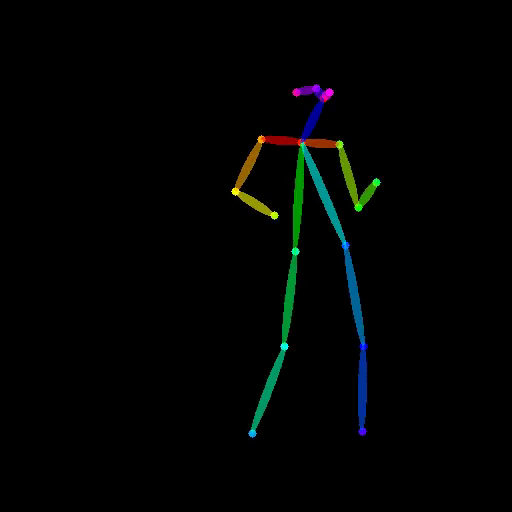

In [64]:
dataset = TuneAVideoControlNetDataset("../data/original.mp4", prompt="hoge", controlnet_hint_path="../data/openpose.mp4")
dataset.prompt_ids = 1
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)
for batch in dataloader:
    x = batch["pixel_values"]
    control = batch["pixel_values_hint"]
    # assume control is same across batch
    control = control[0] # f b h w
    print(control.shape)
    img = Image.fromarray((control.cpu().squeeze()[7].permute(1, 2, 0).numpy() * 127.5 + 127.5).astype(np.uint8))
img